In [41]:
%pylab inline
import datetime
import matplotlib.pyplot as plt
import numpy as np
from os import listdir

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [42]:
def read_data(name):
    data = []
    for line in open(name, 'r'):
        spl = line.split('|')
        date, users = datetime.datetime.strptime(spl[1].strip(), "%Y-%m-%d"), int(spl[3].split(' ')[1].replace(',', ''))
        data.append([date, users])

    return array(data)

In [43]:
def plot_data(data, legend = None):
    plot(range(len(data)), data[:,1], label = legend)
    xticks(range(len(data)), [x.strftime("%d-%m") for x in data[:,0]],  rotation=70)

In [44]:
DATA_DIR = 'data/'
dirs = listdir(DATA_DIR)
dirs

['15-05', '09-04']

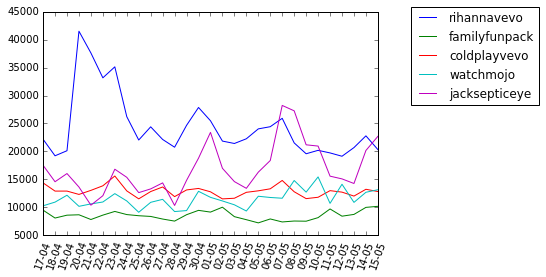

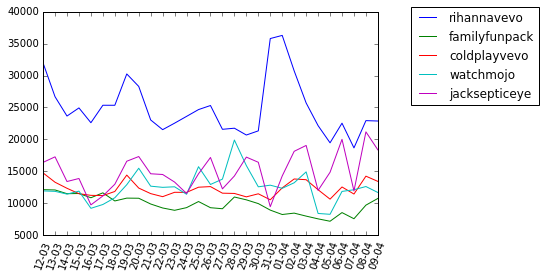

In [45]:
convert_dir = lambda _dir: DATA_DIR + _dir + '/'
contents = lambda _dir: set(listdir(convert_dir(_dir)))

names = ['rihannavevo', 'familyfunpack', 'coldplayvevo', 'watchmojo', 'jacksepticeye']
# list(contents(dirs[0]) & contents(dirs[1]))[:5]
data = {}
for name in names:
    data[name] = []
for _dir in dirs:
    directory = convert_dir(_dir)
    for name in names:
        datum = read_data(directory + name)
        plot_data(datum, legend=name)
        data[name].append(datum)
    legend(bbox_to_anchor=(1.5, 1.05))
    show()

In [46]:
import lasagne
import theano
import theano.tensor as T

In [60]:
def normalize(arr):
    a = []
    arr = list(map(lambda x: x[1], arr))
    arr = list(zip(*[arr[i:] for i in range(4)]))
    for i in range(len(arr)):
        foo = [i]
        foo += list(arr[i][:-1])
        diff = arr[i][-1] - arr[i][-2]
        foo += [sign(diff)]
        a.append(foo)
    return array(a)[:, None]

In [61]:
training, test = map(normalize, data['coldplayvevo'])

In [62]:
train_scale = abs(training).max(0)
train_scale[0, -1] = 1

In [63]:
train_shift = training.mean(0) / train_scale
train_shift[0, -1] = -1

In [64]:
train_scaled, test_scaled = map(lambda x: x/train_scale - train_shift, [training, test])

In [65]:
input_var = T.row('X', dtype='float64')
target_var = T.vector('y', dtype='int64')

In [66]:
network = lasagne.layers.InputLayer((1, 4), input_var)

In [67]:
network = lasagne.layers.DenseLayer(network,
                                    100,
                                     W=lasagne.init.GlorotUniform(),
                                    nonlinearity = lasagne.nonlinearities.rectify)
network = lasagne.layers.DenseLayer(network,
                                    3,
                                    nonlinearity = lasagne.nonlinearities.softmax)

In [68]:
# create loss function
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean() + 1e-4 * lasagne.regularization.regularize_network_params(
        network, lasagne.regularization.l2)

# create parameter update expressions
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=0.01,
                                            momentum=0.9)
acc = T.mean(T.eq(T.argmax(prediction, axis=1), target_var),
                      dtype=theano.config.floatX)

In [69]:
# compile training function that updates parameters and returns training loss
train_fn = theano.function([input_var, target_var], [loss, acc], updates=updates)

In [70]:
test_prediction = lasagne.layers.get_output(network, deterministic=True)
predict_fn = theano.function([input_var], T.argmax(test_prediction, axis=1))

In [71]:
import tqdm

In [72]:
for epoch in (range(2000)):
    loss = array([0., 0.])
    for batch in train_scaled:
        input_batch = batch[:, :-1]
        target_batch = batch[:, -1]
        loss += train_fn(input_batch, [round(target_batch[0])])
    if epoch % 200 == 0:
        avg_loss, avg_acc = loss / len(training)
        print("Epoch %d: Loss %g Acc: %g" % (epoch + 1, avg_loss, avg_acc))

Epoch 1: Loss 0.98045 Acc: 0.461538
Epoch 201: Loss 0.330012 Acc: 0.846154
Epoch 401: Loss 0.102039 Acc: 1
Epoch 601: Loss 0.0743719 Acc: 1
Epoch 801: Loss 0.0702881 Acc: 1
Epoch 1001: Loss 0.0688763 Acc: 1
Epoch 1201: Loss 0.0681184 Acc: 1
Epoch 1401: Loss 0.0676485 Acc: 1
Epoch 1601: Loss 0.0672157 Acc: 1
Epoch 1801: Loss 0.0669895 Acc: 1


In [33]:
def plot_results(data_set):
    data = []
    for var in data_set:
        test_batch = var[:, :-1]
        prediction = predict_fn(test_batch)
        data.append([var[0,0]+0.5, var[0, -1], prediction[0]])
    data = array(data)
    plot(data[:, 0], data[:, 1], label='expected', color='r')
    plot(data[:, 0], data[:, 2], label='computed', color='b')
    legend()

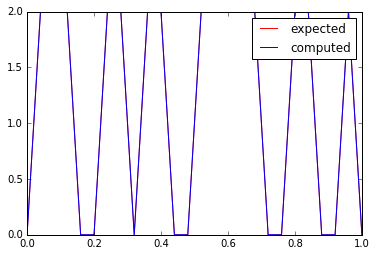

In [35]:
plot_results(train_scaled)

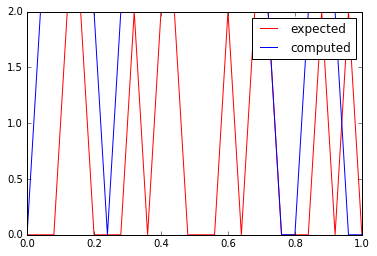

In [36]:
plot_results(test_scaled)